# Libraries

In [184]:
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PowerTransformer

## Load data and resample

In [185]:
# load the dataset
def load_dataset(file_path):
    # load the dataset as a dataframe
    data_df = pd.read_pickle(file_path)
    # correct data types
    fix_cols = data_df.columns[data_df.dtypes == 'object']
    data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')
    # remove redundant features
    data_df.drop(['total_review_count', 'halal_review_count', 'halal_negation_count'], inplace=True, axis=1)
    # split into features and target
    X, y = data_df.drop('halal', axis=1), data_df.halal
    return X, y

# define resampling method
def split_and_resample(X, y, test_size=0, resampling=None):
    if test_size > 0:
        # setting up testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
        x_train, x_test, y_train, y_test = X, pd.DataFrame(columns=X.columns, dtype=X.dtypes.values),\
                                            y, pd.Series(name=y.name, dtype=y.dtypes)
    # concatenate our training data back together
    X = pd.concat([x_train, y_train], axis=1)
    # separate minority and majority classes
    min_class = X[X.halal==X.halal.value_counts().sort_values().index[0]]
    max_class = X[X.halal==X.halal.value_counts().sort_values().index[1]]
    if not resampling:
        return x_train, y_train, x_test, y_test
    # oversampling minority
    if resampling == 'oversample':
        new_min_class = resample(min_class, replace=True, n_samples=(len(max_class)))
        upsampled = pd.concat([max_class, new_min_class])
        return upsampled.drop('halal', axis=1), upsampled.halal, x_test, y_test
    elif resampling == 'undersample':
        new_max_class = resample(max_class, replace=True, n_samples=(len(min_class)))
        downsampled = pd.concat([new_max_class, min_class])
        return downsampled.drop('halal', axis=1), downsampled.halal, x_test, y_test
    elif resampling == 'SMOTE':
        x_train, y_train = SMOTE().fit_sample(x_train, y_train)
        return x_train, y_train, x_test, y_test

# define models to test
def get_models():
    models = list()
    # BASE
    models.append(DummyClassifier(strategy='constant', constant=1))
    # CART
    models.append(DecisionTreeClassifier(max_depth=15)) # max depth set to 15 to avoid overfitting
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    # RF
    models.append(RandomForestClassifier(n_estimators=10, max_depth=15))
    # XGBoost
    models.append(XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=15))
    return models

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
   # calculate precision-recall curve
   p, r, _ = precision_recall_curve(y_true, probas_pred)
   # calculate area under curve
   return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, error_score='raise')
    return scores

>DummyClassifier 0.866 (0.003)
>DecisionTreeClassifier 0.880 (0.023)
>Pipeline 0.907 (0.020)
>RandomForestClassifier 0.911 (0.027)
>XGBClassifier 0.918 (0.020)


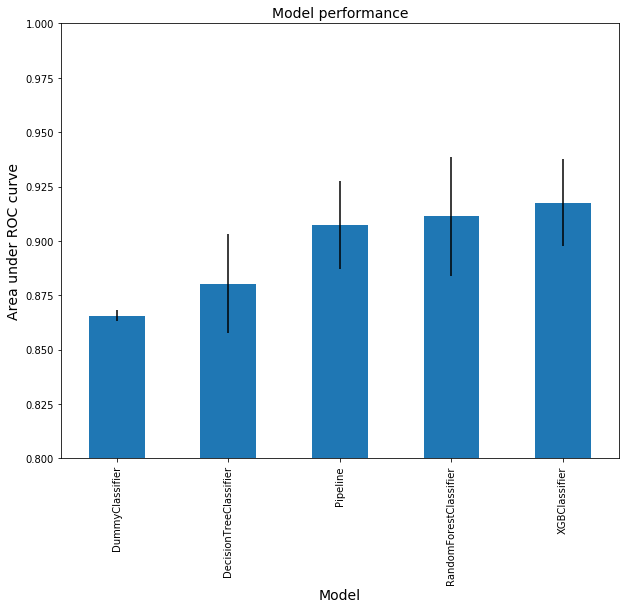

In [186]:
# split to train and test
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

# define models
models = get_models()

# evaluate each model
results = list()
for i, model in enumerate(models):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, model)
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (model.__class__.__name__, mean(scores), std(scores)))

# plot the results
plot_df = pd.DataFrame(columns=['models', 'results'])
plot_df['models'] = [model.__class__.__name__ for model in models]
plot_df['results'] = [result.tolist() for result in results]
plot_df['mean'] = plot_df['results'].apply(mean)
plot_df['sd'] = plot_df['results'].apply(std)
ax = plot_df.plot(kind='bar', y='mean', x='models', yerr='sd', legend=False, figsize=(10,8))
ax.set_ylim(0.8,1)
ax.set_title('Model performance', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylabel('Area under ROC curve', size=14)
plt.show()

## Compare different resampling methods

In [167]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# define models and resampling methods
models = get_models()
resampling = [None, 'oversample', 'undersample', 'SMOTE']
# evaluate each model
results = list()
for resample_method in resampling:
    # split and oversample
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling=resample_method)
    print('>>%s: ' % resample_method.upper())
    for model in models:
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, model)
        results.append(scores)
        # summarize performance
        print('>%s %.3f (%.3f)' % (model.__class__.__name__, mean(scores), std(scores)))
        # evaluate against test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(' >accuracy: %.3f'  % accuracy_score(y_test, y_pred))
        print(' >recall: %.3f' % recall_score(y_test, y_pred))
    print()

>>NONE: 
>DummyClassifier 0.863 (0.003)
 >accuracy: 0.750
 >recall: 1.000
>DecisionTreeClassifier 0.884 (0.027)
 >accuracy: 0.726
 >recall: 0.841
>Pipeline 0.898 (0.027)
 >accuracy: 0.792
 >recall: 0.849
>RandomForestClassifier 0.903 (0.024)
 >accuracy: 0.768
 >recall: 0.857
>XGBClassifier 0.914 (0.021)
 >accuracy: 0.774
 >recall: 0.881

>>OVERSAMPLE: 
>DummyClassifier 0.750 (0.000)
 >accuracy: 0.726
 >recall: 1.000
>DecisionTreeClassifier 0.923 (0.029)
 >accuracy: 0.720
 >recall: 0.721
>Pipeline 0.897 (0.026)
 >accuracy: 0.661
 >recall: 0.689
>RandomForestClassifier 0.944 (0.021)
 >accuracy: 0.708
 >recall: 0.787
>XGBClassifier 0.950 (0.027)
 >accuracy: 0.714
 >recall: 0.803

>>UNDERSAMPLE: 
>DummyClassifier 0.750 (0.007)
 >accuracy: 0.762
 >recall: 1.000
>DecisionTreeClassifier 0.807 (0.049)
 >accuracy: 0.714
 >recall: 0.688
>Pipeline 0.829 (0.060)
 >accuracy: 0.637
 >recall: 0.594
>RandomForestClassifier 0.843 (0.059)
 >accuracy: 0.696
 >recall: 0.656
>XGBClassifier 0.842 (0.070)
 >

## Feature importance from Random Forest w/o resampling

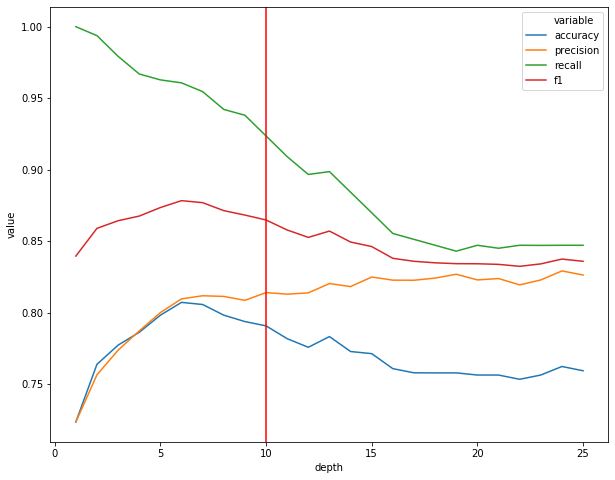

In [168]:
# load the dataset
X, y = load_dataset(file_path)
# split and oversample
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)
# initialize RF with different depths
depths = range(1, 26)
plot_df = pd.DataFrame(columns=['depth', 'accuracy', 'precision', 'recall', 'f1'], dtype=float)
plot_df['depth'] = depths
scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'}

for i, depth in plot_df['depth'].iteritems(): 
    model = RandomForestClassifier(max_depth=depth)
    # train model and collect metrics
    cv_scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = 10, n_jobs = -1)
    plot_df.loc[i, 'accuracy'] = cv_scores['test_acc'].mean()
    plot_df.loc[i, 'precision'] = cv_scores['test_prec'].mean()
    plot_df.loc[i, 'recall'] = cv_scores['test_rec'].mean()
    plot_df.loc[i, 'f1'] = cv_scores['test_f1'].mean()
    
# visualize decision tree metrics vs max_depth
plt.figure(figsize=(10,8))
sns.lineplot(x='depth', y='value', hue='variable', data=pd.melt(plot_df, ['depth']))
plt.axvline(x=10, color='red')
plt.show()

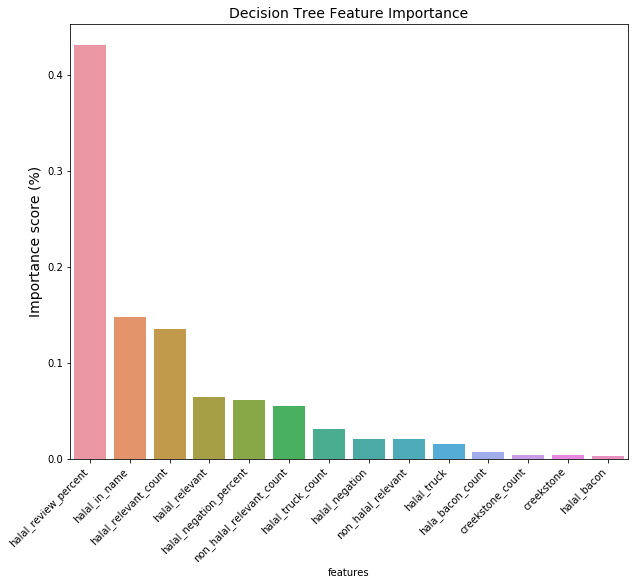

In [11]:
# use max depth of 10
model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

# Feature importance from RF
plot_df = pd.DataFrame(data={'importances': model.feature_importances_, 'features': X.columns})

# plot
plt.figure(figsize=(10,8))
g = sns.barplot(x=plot_df['features'], y=plot_df['importances'],
                order=plot_df.sort_values('importances', ascending=False).features)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Decision Tree Feature Importance', size=14)
g.set_ylabel('Importance score (%)', size=14)
plt.show()

## Trying RF with class_weight

In [195]:
# split and oversample
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, {0:25, 1:75}]
param_grid = dict(class_weight=balance)

# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.666293 using {'class_weight': {0: 25, 1: 75}}
0.641797 (0.060827) with: {'class_weight': {0: 100, 1: 1}}
0.655358 (0.051930) with: {'class_weight': {0: 10, 1: 1}}
0.656736 (0.045468) with: {'class_weight': {0: 1, 1: 1}}
0.663378 (0.054620) with: {'class_weight': {0: 1, 1: 10}}
0.666083 (0.052082) with: {'class_weight': {0: 1, 1: 100}}
0.666293 (0.052975) with: {'class_weight': {0: 25, 1: 75}}


### There is not significant difference.

## Trying XGBoost with class_weight